<a href="https://colab.research.google.com/github/Elwing-Chou/tibaml0922/blob/main/transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
f = zipfile.ZipFile("/content/drive/MyDrive/additional/train.zip")
f.extractall()

In [2]:
import glob
import pandas as pd
dogs = glob.glob("train/dog.*")
cats = glob.glob("train/cat.*")
df = pd.DataFrame({
    "path":dogs + cats,
    "ans":[0] * len(dogs) + [1] * len(cats)
})
df

,path,ans
0,train/dog.5450.jpg,0
1,train/dog.1933.jpg,0
2,train/dog.8744.jpg,0
3,train/dog.2438.jpg,0
4,train/dog.5943.jpg,0
...,...,...
24995,train/cat.8920.jpg,1
24996,train/cat.1859.jpg,1
24997,train/cat.8150.jpg,1
24998,train/cat.8976.jpg,1


In [3]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization
cnn = VGG16(include_top=False, input_shape=(224, 224, 3))
for l in cnn.layers:
    l.trainable = False
layers = [
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(2, activation="softmax")
]
model = Sequential(cnn.layers + layers)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [4]:
# y: 做one-hot encoding很耗費ram, 直接使用Sparse省RAM又方便
from tensorflow.keras.losses import SparseCategoricalCrossentropy
model.compile(loss=SparseCategoricalCrossentropy(),
              optimizer="adam",
              metrics=["accuracy"])

[[[-6.6939003e+01 -6.8778999e+01 -7.1680000e+01]
  [-6.5939003e+01 -6.7778999e+01 -7.0680000e+01]
  [-6.5939003e+01 -6.7778999e+01 -7.0680000e+01]
  ...
  [ 8.0609970e+00 -7.7899933e-01  3.3199997e+00]
  [-2.5939003e+01 -3.6778999e+01 -3.2680000e+01]
  [-1.8939003e+01 -2.9778999e+01 -2.7680000e+01]]

 [[-6.6939003e+01 -6.8778999e+01 -7.1680000e+01]
  [-6.5939003e+01 -6.7778999e+01 -7.0680000e+01]
  [-6.5939003e+01 -6.7778999e+01 -7.0680000e+01]
  ...
  [ 3.0609970e+00 -5.7789993e+00 -1.6800003e+00]
  [-3.0939003e+01 -4.1778999e+01 -3.8680000e+01]
  [-2.3939003e+01 -3.4778999e+01 -3.2680000e+01]]

 [[-6.6939003e+01 -6.8778999e+01 -7.1680000e+01]
  [-6.5939003e+01 -6.7778999e+01 -7.0680000e+01]
  [-6.5939003e+01 -6.7778999e+01 -7.0680000e+01]
  ...
  [ 6.0997009e-02 -8.7789993e+00 -4.6800003e+00]
  [-3.3939003e+01 -4.4778999e+01 -4.0680000e+01]
  [-2.6939003e+01 -3.7778999e+01 -3.5680000e+01]]

 ...

 [[-6.1939003e+01 -7.6778999e+01 -8.3680000e+01]
  [-6.1939003e+01 -7.6778999e+01 -8.368

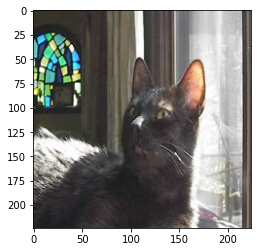

In [5]:
import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

p = df["path"]
idx = random.randint(0, len(p)-1)
img = Image.open(p[idx]).resize((224, 224)).convert("RGB")
img_np = np.array(img)
img_np_pre = preprocess_input(img_np)
print(img_np_pre)
plt.imshow(img)

In [6]:
x = np.array(df["path"])
y = np.array(df["ans"])

In [7]:
def data_generator(x, y, batch_size=20):
    while True:
        idx = np.random.randint(0, len(x), size=batch_size)
        x_batch, y_batch = x[idx], y[idx]
        x_final = []
        for path in x_batch:
            img = Image.open(path).resize((224, 224)).convert("RGB")
            img_pre = preprocess_input(np.array(img))
            x_final.append(img_pre)
        x_final = np.array(x_final)
        y_batch = np.array(y_batch)
        yield (x_final, y_batch)
gen = data_generator(x, y)
x_gen, y_gen = gen.__next__()
print(x_gen.shape)
print(y_gen.shape)
# print(x_gen)
# print(y_gen)

(20, 224, 224, 3)
(20,)


In [8]:
from sklearn.model_selection import train_test_split
dogx = x[y == 0]
catx = x[y == 1]
dog1000 = np.random.choice(dogx, 1000, replace=False)
dog900, dog100 = train_test_split(dog1000, test_size=0.1)
cat1000 = np.random.choice(catx, 1000, replace=False)
cat900, cat100 = train_test_split(cat1000, test_size=0.1)
x_train = np.concatenate((dog900, cat900))
y_train = np.array([0] * len(dog900) + [1] * len(cat900))
x_test = np.concatenate((dog100, cat100))
y_test = np.array([0] * len(dog100) + [1] * len(cat100))
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1800,)
(200,)
(1800,)
(200,)


In [9]:
train_generator = data_generator(x_train, y_train)
test_generator = data_generator(x_test, y_test)

In [13]:
# 50 * 20 -> 訓練
# 5 * 20 -> 測試
model.fit_generator(train_generator,
                    steps_per_epoch=50,
                    epochs=5,
                    validation_data=test_generator,
                    validation_steps=5)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
50/50 [==============================] - 13s 253ms/step - loss: 0.1141 - accuracy: 0.9680 - val_loss: 0.1392 - val_accuracy: 0.9600
Epoch 2/5
50/50 [==============================] - 13s 252ms/step - loss: 0.1229 - accuracy: 0.9640 - val_loss: 0.1640 - val_accuracy: 0.9100
Epoch 3/5
50/50 [==============================] - 13s 252ms/step - loss: 0.1138 - accuracy: 0.9560 - val_loss: 0.1444 - val_accuracy: 0.9300
Epoch 4/5
50/50 [==============================] - 12s 249ms/step - loss: 0.1070 - accuracy: 0.9630 - val_loss: 0.3262 - val_accuracy: 0.9400
Epoch 5/5
50/50 [==============================] - 13s 252ms/step - loss: 0.0921 - accuracy: 0.9720 - val_loss: 0.1908 - val_accuracy: 0.9400


In [14]:
testx, testy = test_generator.__next__()
model.predict(testx)

array([[9.9915075e-01, 8.4919704e-04],
       [9.9986553e-01, 1.3450489e-04],
       [2.9975664e-02, 9.7002441e-01],
       [9.8650289e-01, 1.3497070e-02],
       [2.4267626e-03, 9.9757320e-01],
       [1.0286223e-02, 9.8971379e-01],
       [9.6058244e-01, 3.9417587e-02],
       [9.9988508e-01, 1.1487684e-04],
       [2.0625412e-03, 9.9793744e-01],
       [9.4927830e-01, 5.0721757e-02],
       [8.1408173e-03, 9.9185914e-01],
       [2.0625412e-03, 9.9793744e-01],
       [9.2389405e-01, 7.6105952e-02],
       [4.5070818e-01, 5.4929185e-01],
       [9.9956137e-01, 4.3861908e-04],
       [2.9975664e-02, 9.7002441e-01],
       [9.9872005e-01, 1.2799938e-03],
       [1.4425410e-03, 9.9855751e-01],
       [9.9995375e-01, 4.6305497e-05],
       [9.9610102e-01, 3.8989834e-03]], dtype=float32)

In [20]:
ori_imgs = []
for p in x_test:
    img = Image.open(p).resize((224, 224)).convert("RGB")
    ori_imgs.append(np.array(img))
ori_imgs = np.array(ori_imgs)
preprocess_imgs = preprocess_input(ori_imgs)
pre = model.predict(preprocess_imgs).argmax(axis=1)

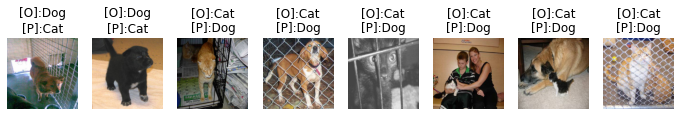

In [21]:
trans = ["Dog", "Cat"]
idx = np.nonzero(pre != y_test)[0]
pre_false_img = ori_imgs[idx]
pre_false_val = pre[idx]
pre_false_ori = y_test[idx]

plt.figure(figsize=(15, 15))
width = 10
height = len(idx) // width + 1
for i in range(len(idx)):
    plt.subplot(height, width, i+1)
    t = "[O]:{}\n[P]:{}".format(trans[pre_false_ori[i]],
                                trans[pre_false_val[i]])
    plt.title(t)
    plt.axis("off")
    plt.imshow(pre_false_img[i])


Enter:https://i2.kknews.cc/SIG=2190q5d/16q10001so19697p3r5n.jpg


/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


預測: Dog
機率: [0.6574027  0.34259728]


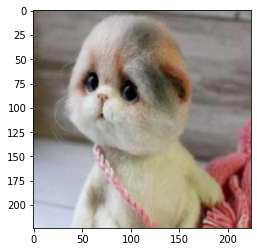

In [26]:
import requests
url = input("Enter:")
response = requests.get(url, stream=True, verify=False)
img = Image.open(response.raw).resize((224, 224)).convert("RGB")
img_np = preprocess_input(np.array(img).reshape(1, 224, 224, 3))
proba = model.predict(img_np)
ans = proba.argmax(axis=1)
print("預測:", trans[ans[0]])
print("機率:", proba[0])
plt.imshow(img)